In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from tqdm import tqdm
from typing import List, Union, Dict

checkpoints_dir = "/data/n.dallanoce/weights/mbart_ft_en-fr-Mf1_weights_anlsys/"
directories = os.listdir(checkpoints_dir)
list_models: Dict[str, Union[MBartForConditionalGeneration, MT5ForConditionalGeneration]] = {}
print(f"Loading these models: {directories}")
for i, chckpnt in enumerate(tqdm(directories)):
    if chckpnt.startswith("checkpoint"):
        model_dir = os.path.join(checkpoints_dir, chckpnt)
        list_models[chckpnt] = AutoModelForSeq2SeqLM.from_pretrained(os.path.abspath(model_dir), output_attentions=True)

Loading these models: ['checkpoint-5000', 'checkpoint-10000', 'checkpoint-15000', 'checkpoint-20000', 'checkpoint-25000', 'checkpoint-30000', 'checkpoint-35000', 'checkpoint-40000', 'checkpoint-45000', 'checkpoint-50000', 'checkpoint-55000', 'checkpoint-60000', 'checkpoint-65000', 'checkpoint-70000', 'checkpoint-75000', 'checkpoint-80000', 'checkpoint-85000', 'checkpoint-90000', 'checkpoint-95000', 'checkpoint-100000']


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


In [5]:
def norm_and_plot(matrix_1: torch.Tensor, matrix_2: torch.Tensor, plot=True, cmap="coolwarm"):
    if plot:
        sns.heatmap(torch.abs(matrix_1 - matrix_2).numpy(), cmap=cmap)
        plt.show()
    return torch.norm(matrix_1 - matrix_2, p="fro")

In [6]:
from transformers import MBartConfig

tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5")
mbart_config = MBartConfig(encoder_layers=6, decoder_layers=6,
                           encoder_ffn_dim=2048, decoder_ffn_dim=2048,
                           encoder_attention_heads=8, decoder_attention_heads=8,
                           d_model=512, max_length=128, vocab_size=tok.vocab_size, dropout=0.1)
random_model: MBartForConditionalGeneration = MBartForConditionalGeneration(mbart_config)
random_weight = random_model.model.shared.weight

pre_trained_model: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/data/n.dallanoce/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000", output_attentions=True)
pre_tr_weight: torch.Tensor = pre_trained_model.model.shared.weight

only_ft_model: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/data/n.dallanoce/weights/mbart_ft_en-fr-Mf1_ft_only/checkpoint-100000", output_attentions=True)
only_ft_weight: torch.Tensor = only_ft_model.model.shared.weight

last_ft_model = list(list_models.values())[-1]

# Analisys on Embeddings

In [7]:
emb_weights: Dict[str, torch.Tensor] = {}
for k, v in list_models.items():
    emb_weights[k] = v.model.shared.weight

In [8]:
last_ckcpt_weight = list(emb_weights.values())[-1]
plot = False
with torch.no_grad():
    print(f"norm random - last check. finetuning {norm_and_plot(random_weight, last_ckcpt_weight, plot=plot)}")
    print(f"norm random - pretrained {norm_and_plot(random_weight, pre_tr_weight, plot=plot)}")
    print(f"norm pretrained - last check. finetuning {norm_and_plot(pre_tr_weight, last_ckcpt_weight, plot=plot)}")

norm random - last check. finetuning 461.94757080078125
norm random - pretrained 274.3450012207031
norm pretrained - last check. finetuning 305.90960693359375


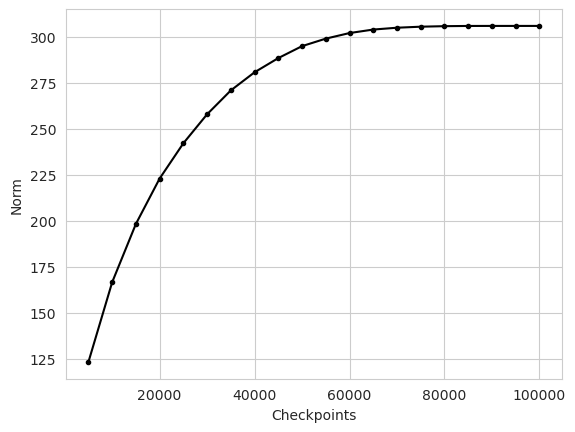

In [7]:
import matplotlib.pyplot as plt

with torch.no_grad():
    plotting = {int(c.split("-")[-1]): float(torch.norm(w - pre_tr_weight)) for c, w in emb_weights.items()}

plt.plot(plotting.keys(), plotting.values(), ".k-")
plt.xlabel("Checkpoints")
plt.ylabel("Norm")
plt.show()

In [2]:
from utilities.models import get_all_mt6_models

mt6_modes = get_all_mt6_models()

0    0.972403
1    0.943877
2    0.959426
3    0.926033
dtype: float32


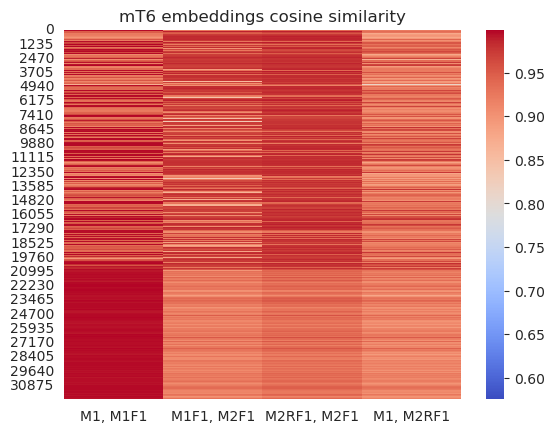

In [6]:
embed_m1 = mt6_modes["M1"].shared.weight
embed_m2 = mt6_modes["M2"].shared.weight
embed_m1f1 = mt6_modes["M1F1"].shared.weight
embed_m2f2 = mt6_modes["M2F2"].shared.weight
embed_m2f1 = mt6_modes["M2F1"].shared.weight
embed_m2f1_r = mt6_modes["M2F1_replay"].shared.weight
embed_m3f1 = mt6_modes["M3F1"].shared.weight
embed_ft_de = mt6_modes["MF2_ft_only"].shared.weight

col_names = ['M1, M1F1', 'M1F1, M2F1', 'M2RF1, M2F1', 'M1, M2RF1']

with torch.no_grad():
    df_emb = pd.DataFrame([torch.nn.functional.cosine_similarity(embed_m1, embed_m1f1).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1f1, embed_m2f1).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1f1, embed_m2f1_r).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1, embed_m2f1_r).numpy(),
                           #torch.nn.functional.cosine_similarity(embed_m2f2, embed_ft_de).numpy(),
                           ])

print(df_emb.T.mean(axis=0))

g = sns.heatmap(df_emb.T, cmap="coolwarm")
g.set(title="mT6 embeddings cosine similarity")
g.set_xticklabels(col_names)
plt.show()

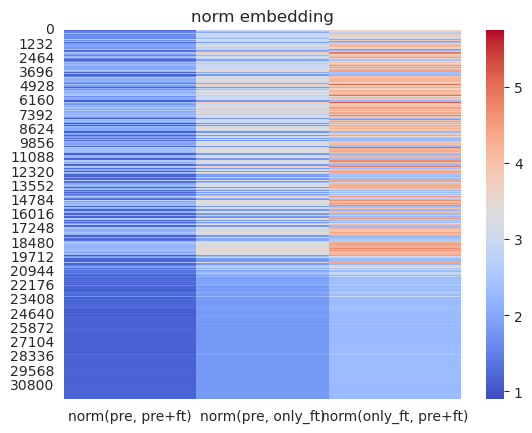

              0         1         2
0      1.145269  1.871305  2.378913
1      1.162605  1.762806  2.274579
2      1.428666  2.826817  3.744272
3      2.489116  2.437488  3.312025
4      1.160970  1.802219  2.294156
...         ...       ...       ...
32025  1.182135  1.802983  2.302915
32026  1.169279  1.791933  2.287178
32027  1.167680  1.787268  2.283651
32028  1.164113  1.820174  2.313219
32029  1.162238  1.830574  2.326193

[32030 rows x 3 columns]


In [67]:
norm_emb = np.zeros((last_ckcpt_weight.shape[0], 3))
with torch.no_grad():
    for i in range(last_ckcpt_weight.shape[0]):
        norm_emb[i, 0] = torch.norm(last_ckcpt_weight[i, :] - pre_tr_weight[i, :])
        norm_emb[i, 1] = torch.norm(only_ft_weight[i, :] - pre_tr_weight[i, :])
        norm_emb[i, 2] = torch.norm(only_ft_weight[i, :] - last_ckcpt_weight[i, :])

g = sns.heatmap(norm_emb, cmap="coolwarm")
g.set(title="norm embedding")
g.set_xticklabels(['norm(pre, pre+ft)', 'norm(pre, only_ft)', 'norm(only_ft, pre+ft)'])
plt.show()
print(pd.DataFrame(norm_emb))

In [10]:
# Requires long time
# for k, w in tqdm(emb_weights.items()):
#     with torch.no_grad():
#         print(f"{k}, norm {norm_and_plot(w, pre_tr_weight)}")

# Analysis on Encoder Last Hidden state

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")
tok_out = tokenizer("Hello how are you? This is my dog.", return_tensors="pt")
tokenizer.batch_decode(tok_out['input_ids'].squeeze())

['Hello',
 'how',
 'are',
 'you',
 '?',
 'This',
 'is',
 'my',
 'dog',
 '.',
 '</s>',
 'en_XX']

In [12]:
with torch.no_grad():
    seq2seq_out_pre = pre_trained_model(**tok_out)
    seq2seq_out_rand = random_model(**tok_out)
    last_ft_model = list(list_models.values())[-1]
    seq2seq_out_fine = last_ft_model(**tok_out)
    seq2seq_out_only_fine = only_ft_model(**tok_out)

In [13]:
last_hidd_state_pre = seq2seq_out_pre['encoder_last_hidden_state'].squeeze().T
last_hidd_state_rand = seq2seq_out_rand['encoder_last_hidden_state'].squeeze().T
last_hidd_state_fine = seq2seq_out_fine['encoder_last_hidden_state'].squeeze().T
last_hidd_state_only_fine = seq2seq_out_only_fine['encoder_last_hidden_state'].squeeze().T

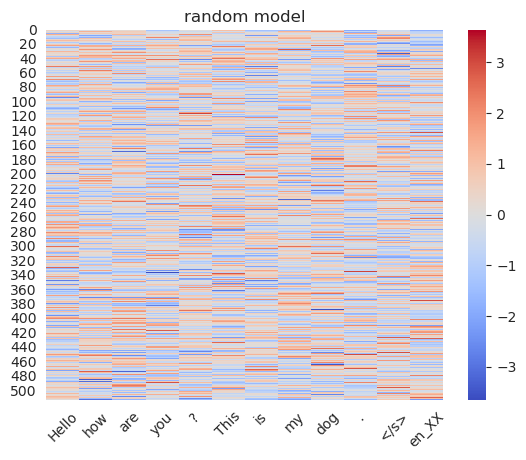

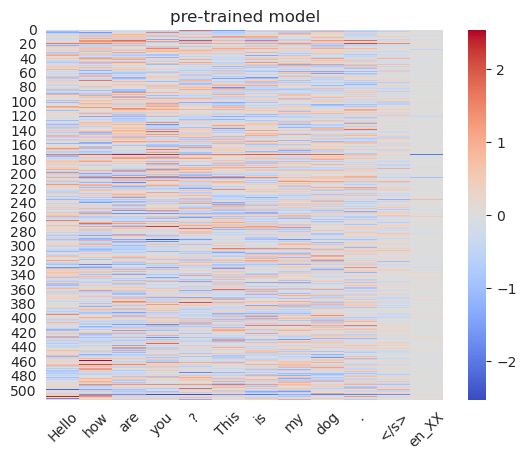

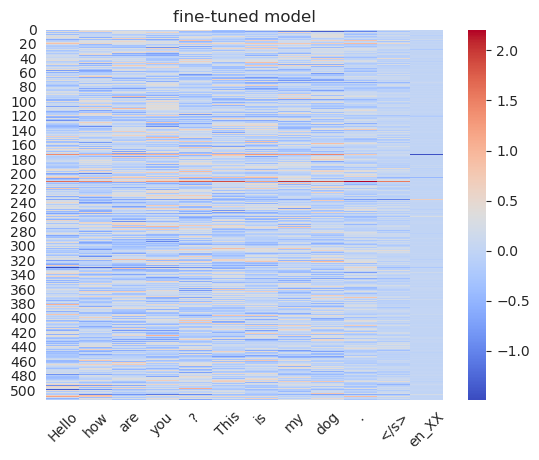

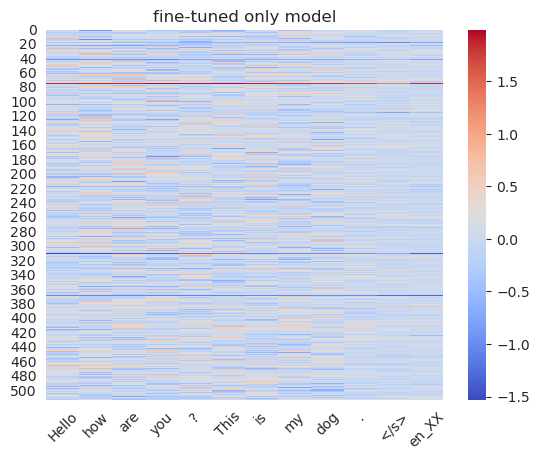

In [14]:
col_names = tokenizer.batch_decode(tok_out['input_ids'].squeeze())
sns.heatmap(pd.DataFrame(last_hidd_state_rand, columns=col_names), cmap="coolwarm").set(title="random model")
plt.xticks(rotation=45)
plt.show()
sns.heatmap(pd.DataFrame(last_hidd_state_pre, columns=col_names), cmap="coolwarm").set(title="pre-trained model")
plt.xticks(rotation=45)
plt.show()
sns.heatmap(pd.DataFrame(last_hidd_state_fine, columns=col_names), cmap="coolwarm").set(title="fine-tuned model")
plt.xticks(rotation=45)
plt.show()
sns.heatmap(pd.DataFrame(last_hidd_state_only_fine, columns=col_names), cmap="coolwarm").set(
    title="fine-tuned only model")
plt.xticks(rotation=45)
plt.show()

In [15]:
plot = False
with torch.no_grad():
    print(norm_and_plot(last_hidd_state_rand, last_hidd_state_pre, plot))
    print(norm_and_plot(last_hidd_state_pre, last_hidd_state_fine, plot))
    print(norm_and_plot(last_hidd_state_rand, last_hidd_state_fine, plot))
    print(norm_and_plot(last_hidd_state_only_fine, last_hidd_state_fine, plot))

tensor(90.0542)
tensor(36.2622)
tensor(82.3631)
tensor(33.2114)


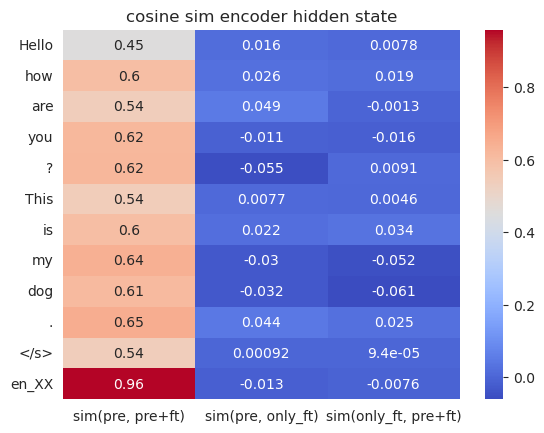

In [16]:
with torch.no_grad():
    cos_sim_pre_fine = torch.nn.functional.cosine_similarity(last_hidd_state_pre, last_hidd_state_fine, dim=0)
    cos_sim_pre_onlyft = torch.nn.functional.cosine_similarity(last_hidd_state_pre, last_hidd_state_only_fine, dim=0)
    cos_sim_onlyft_fine = torch.nn.functional.cosine_similarity(last_hidd_state_only_fine, last_hidd_state_fine, dim=0)
    df_cos_hs = pd.DataFrame([cos_sim_pre_fine.numpy(), cos_sim_pre_onlyft.numpy(), cos_sim_onlyft_fine.numpy()],
                             columns=col_names)

#print(df_cos)
g = sns.heatmap(df_cos_hs.T, cmap="coolwarm", annot=True)
g.set(title="cosine sim encoder hidden state")
#g.set_xticks(range(len(df_cos_hs))) # <--- set the ticks first
g.set_xticklabels(['sim(pre, pre+ft)', 'sim(pre, only_ft)', 'sim(only_ft, pre+ft)'])
plt.show()

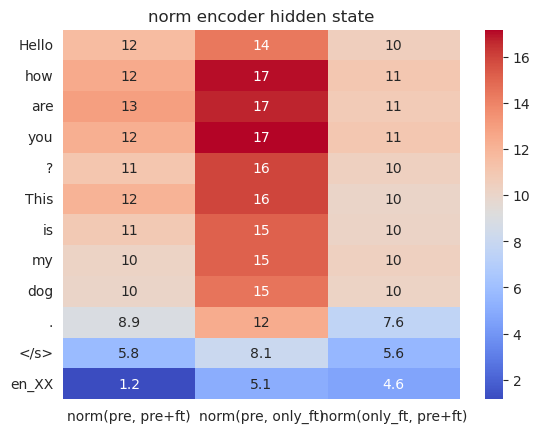

In [17]:
norm_hidd = np.zeros((len(col_names), 3))
with torch.no_grad():
    for i in range(norm_hidd.shape[0]):
        norm_hidd[i, 0] = torch.norm(last_hidd_state_fine[:, i] - last_hidd_state_pre[:, i])
        norm_hidd[i, 1] = torch.norm(last_hidd_state_only_fine[:, i] - last_hidd_state_pre[:, i])
        norm_hidd[i, 2] = torch.norm(last_hidd_state_only_fine[:, i] - last_hidd_state_fine[:, i])

g = sns.heatmap(norm_hidd, cmap="coolwarm", annot=True)
g.set(title="norm encoder hidden state")
g.set_xticklabels(['norm(pre, pre+ft)', 'norm(pre, only_ft)', 'norm(only_ft, pre+ft)'])
g.set_yticklabels(col_names)
plt.yticks(rotation=0)
plt.show()

# Analysis on Logits

In [18]:
logits_ft = seq2seq_out_fine['logits'].squeeze()
logits_pre = seq2seq_out_pre['logits'].squeeze()
logits_rand = seq2seq_out_rand['logits'].squeeze()
logits_onlyft = seq2seq_out_only_fine['logits'].squeeze()

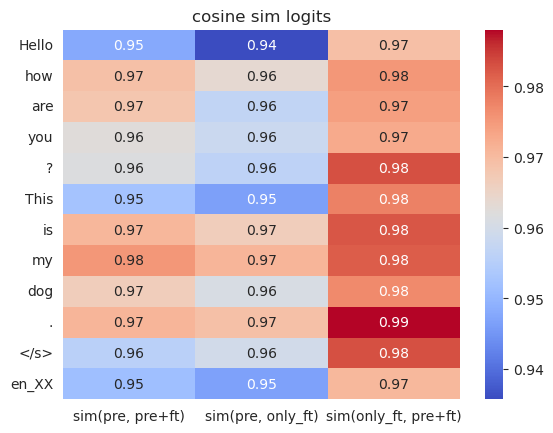

In [19]:
cos_sim_logits_ft_pre = torch.nn.functional.cosine_similarity(logits_ft, logits_pre, dim=1)
cos_sim_logits_onlyft_pre = torch.nn.functional.cosine_similarity(logits_onlyft, logits_pre, dim=1)
cos_sim_logits_onlyft_ft = torch.nn.functional.cosine_similarity(logits_onlyft, logits_ft, dim=1)

df_cos_logits = pd.DataFrame(
    [cos_sim_logits_ft_pre.numpy(), cos_sim_logits_onlyft_pre.numpy(), cos_sim_logits_onlyft_ft.numpy()],
    columns=col_names)
#print(df_cos_logits)
g = sns.heatmap(df_cos_logits.T, cmap="coolwarm", annot=True)
g.set(title="cosine sim logits")
g.set_xticklabels(['sim(pre, pre+ft)', 'sim(pre, only_ft)', 'sim(only_ft, pre+ft)'])
plt.show()

In [20]:
logits_pre.shape

torch.Size([12, 32030])

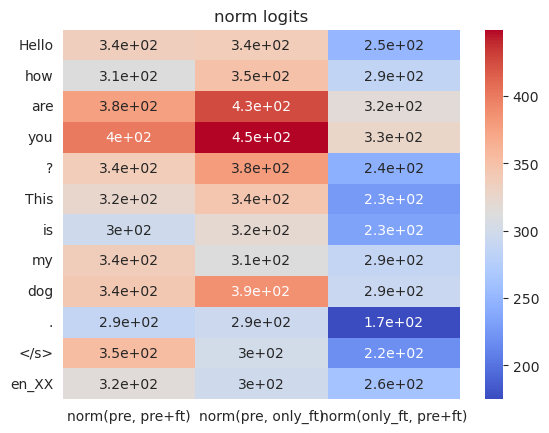

In [21]:
norm_logits = np.zeros((len(col_names), 3))
with torch.no_grad():
    for i in range(norm_hidd.shape[0]):
        norm_logits[i, 0] = torch.norm(logits_ft[i, :] - logits_pre[i, :])
        norm_logits[i, 1] = torch.norm(logits_onlyft[i, :] - logits_pre[i, :])
        norm_logits[i, 2] = torch.norm(logits_onlyft[i, :] - logits_ft[i, :])

g = sns.heatmap(norm_logits, cmap="coolwarm", annot=True)
g.set(title="norm logits")
g.set_xticklabels(['norm(pre, pre+ft)', 'norm(pre, only_ft)', 'norm(only_ft, pre+ft)'])
g.set_yticklabels(col_names)
plt.yticks(rotation=0)
plt.show()

# Analysis on Attentions

In [7]:
from bertviz import model_view, head_view

In [20]:
from transformers import AutoTokenizer
att_model = pre_trained_model #list(list_models.values())[-1]
tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")

In [21]:
src_txt, tgt_txt = "Hello how are you? This is my dog.", "Bonjour comment allez-vous? C'est mon chien."
inputs = tokenizer(src_txt, text_target = tgt_txt,  return_tensors="pt", add_special_tokens=True)
labels = inputs['labels']
decoder_input_ids = torch.zeros_like(inputs['labels'])
decoder_input_ids[:,0] = inputs['labels'][:,-1]
decoder_input_ids[:,1:] = inputs['labels'][:,:-1]
with torch.no_grad():
    outputs = att_model(input_ids=inputs['input_ids'], decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids.squeeze())

In [22]:
mv = model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text,
    html_action="return",
    display_mode="light"
)
mv

In [23]:
print(mv.data)

<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>      
        <div id="bertviz-146f836c01604c8a8a55bb69bfc6ee47" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Attention: <select id="filter"><option value="0">Encoder</option>
<option value="1">Decoder</option>
<option value="2">Cross</option></select>
            </span>
            <div id='vis'></div>
        </div>
    
<script type="text/javascript">
/**
 * @fileoverview Transformer Visualization D3 javascript code.
 *
 * Based on: https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/visualization/attention.js
 *
 * Change log:
 *
 * 02/01/19  Jesse Vig   Initial implementation
 * 12/31/20  Jesse Vig   Support multiple visualizations in single notebook.
 * 01/19/21  Jesse Vig   Support light/dark modes
 * 02/06/21  Jesse Vig   Move require config from separate jupyter notebook step
 * 05/

In [55]:
hr = head_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text,
    layer=5,
    html_action="return"
)

In [60]:
print(hr.data)

<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>      
        <div id="bertviz-18c503800e474271aeba45c3d7f7ad6f" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Layer: <select id="layer"></select>
                Attention: <select id="filter"><option value="0">Encoder</option>
<option value="1">Decoder</option>
<option value="2">Cross</option></select>
            </span>
            <div id='vis'></div>
        </div>
    
<script type="text/javascript">
/**
 * @fileoverview Transformer Visualization D3 javascript code.
 *
 *
 *  Based on: https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/visualization/attention.js
 *
 * Change log:
 *
 * 12/19/18  Jesse Vig   Assorted cleanup. Changed orientation of attention matrices.
 * 12/29/20  Jesse Vig   Significant refactor.
 * 12/31/20  Jesse Vig   Support multiple visualizations in single notebo

# Other

In [62]:
all_norms = []
with torch.no_grad():
    for i in range(last_ckcpt_weight.shape[0]):
        norma = torch.norm(last_ckcpt_weight[i,:])
        all_norms.append(norma)

In [66]:
np.mean(all_norms)

2.462165

In [65]:
print(last_ft_model)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(32030, 512, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(32030, 512, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 512)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=